# GroupfMRI13a - Automated SRActFlow using ANN-inspired representations
#### Analysis 1 - Full model, SRActFlow decoding
#### Control 1 - Remove nonlinearities


Takuya Ito

10/24/2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
import tools_group_rsa as tools_group
import nibabel as nib
import EmpiricalSRActFlow_ANN_RSA_v2 as esr
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"
import pandas as pd
import time


In [2]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']



basedir = '/projects3/SRActFlow/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

# Load real motor response data

In [3]:
tools_group = reload(tools_group)
nResponses = 2
data_task_rh = np.zeros((len(glasser2),nResponses,len(subjNums)))
data_task_lh = np.zeros((len(glasser2),nResponses,len(subjNums)))

scount = 0
for subj in subjNums:
    data_task_rh[:,:,scount] = np.real(tools_group.loadMotorResponses(subj,hand='Right'))
    data_task_lh[:,:,scount] = np.real(tools_group.loadMotorResponses(subj,hand='Left'))
    scount += 1

#### Identify target vertices

In [4]:
# Set indices for layer-by-layer vertices
targetdir = '/projects3/SRActFlow/data/results/GroupfMRI/MotorResponseDecoding/'
motor_resp_regions_LH = np.loadtxt(targetdir + 'MotorResponseRegions_LH.csv',delimiter=',')
motor_resp_regions_RH = np.loadtxt(targetdir + 'MotorResponseRegions_RH.csv',delimiter=',')
targetROIs = np.hstack((motor_resp_regions_LH,motor_resp_regions_RH))

target_ind = []
for roi in targetROIs:
    roi_ind = np.where(glasser2==roi+1)[0]
    target_ind.extend(roi_ind)
target_ind = np.asarray(target_ind)

# Define functions for motor response decodings

#### Load in FC mappings

In [5]:
tools_group = reload(tools_group)
inputtypes = ['color','ori','pitch','constant']
inputkeys = ['RED','VERTICAL','HIGH','CONSTANT']
fc_input2hidden = {}
eig_input2hidden = {}
i = 0
for inputtype in inputtypes:
    fc_input2hidden[inputkeys[i]], eig_input2hidden[inputkeys[i]] = tools_group.loadGroupActFlowFC(inputtype,pc_space=True)
    i += 1
    
# Load rules to hidden FC mappings
fc_logic2hidden, eig_logic2hidden = tools_group.loadGroupActFlowFC('Logic',pc_space=True)
fc_sensory2hidden, eig_sensory2hidden = tools_group.loadGroupActFlowFC('Sensory',pc_space=True)
fc_motor2hidden, eig_motor2hidden = tools_group.loadGroupActFlowFC('Motor',pc_space=True)

# Load hidden to motor resp mappings
fc_hidden2motorresp, eig_hidden2motorresp = tools_group.loadGroupActFlowFC('hidden2out',pc_space=True)

#### Generate trials to simulate empirical brain computational models

In [6]:
esr = reload(esr)
filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v2.csv' # Good
filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/EmpiricalSRActFlow_AllTrialKeys_15stims_v3.csv' # Great
# filename='/projects3/SRActFlow/data/results/GroupfMRI/RSA/tmp.csv'
# esr.constructTasks(n_stims=15,filename=filename)

trial_metadata = pd.read_csv(filename)

#### Define wrapper function for SRActFlow

In [7]:
esr = reload(esr)
def subjSRActFlow_PCFC((subj,trial_metadata)):
    print('Subject ' + subj + '... Simulating ' + str(len(trial_metadata)) + ' Trials')
    obj = esr.EmpiricalActFlow(subj)
    # Input
    obj.fc_input2hidden = fc_input2hidden
    obj.eig_input2hidden = eig_input2hidden
    # Rules
    obj.fc_logic2hidden = fc_logic2hidden
    obj.eig_logic2hidden = eig_logic2hidden
    obj.fc_sensory2hidden = fc_sensory2hidden
    obj.eig_sensory2hidden = eig_sensory2hidden
    obj.fc_motor2hidden = fc_motor2hidden
    obj.eig_motor2hidden = eig_motor2hidden
    # hidden 2 motor
    obj.fc_hidden2motorresp = fc_hidden2motorresp
    obj.eig_hidden2motorresp = eig_hidden2motorresp
    
    obj.extractAllActivations(trial_metadata)

    actflow = obj.generateActFlowPredictions_PCFC(thresh=0,verbose=False)
    actflow_control = obj.generateActFlowPredictions_PCFC(thresh=None,verbose=False)
    del obj
    return actflow, actflow_control

global fc_input2hidden
global fc_logic2hidden
global fc_sensory2hidden
global fc_motor2hidden

inputs = []
for i in range(len(subjNums)):
    inputs.append((subjNums[i],trial_metadata))

timestart = time.time()
pool = mp.Pool(processes=8)
results = pool.map_async(subjSRActFlow_PCFC,inputs).get()
pool.close()
pool.join()
timeend = time.time()
print "time elapsed:", timeend-timestart

actflow_predictions = np.zeros((len(subjNums),len(target_ind),4))
actflow_predictions_control = np.zeros((len(subjNums),len(target_ind),4))
scount = 0
for result in results:
    actflow_predictions[scount,:,:] = result[0]
    actflow_predictions_control[scount,:,:] = result[1]
    scount += 1



Subject 013... Simulating 960 Trials
Subject 017... Simulating 960 Trials
Subject 023... Simulating 960 Trials
Subject 027... Simulating 960 Trials
Subject 031... Simulating 960 Trials
Subject 034... Simulating 960 Trials
Subject 038... Simulating 960 Trials
Subject 041... Simulating 960 Trials
Subject 032... Simulating 960 Trials
Subject 035... Simulating 960 Trials
Subject 024... Simulating 960 Trials
Subject 042... Simulating 960 Trials
Subject 039... Simulating 960 Trials
Subject 018... Simulating 960 Trials
Subject 014... Simulating 960 Trials
Subject 028... Simulating 960 Trials
Subject 037... Simulating 960 Trials
Subject 043... Simulating 960 Trials
Subject 040... Simulating 960 Trials
Subject 033... Simulating 960 Trials
Subject 026... Simulating 960 Trials
Subject 021... Simulating 960 Trials
Subject 016... Simulating 960 Trials
Subject 030... Simulating 960 Trials
Subject 045... Simulating 960 Trials
Subject 048... Simulating 960 Trials
Subject 053... Simulating 960 Trials
S

#### Compute average activity for each response, for each subject

In [8]:
scount = 0
actflow_rh = np.zeros(data_task_rh.shape)
actflow_lh = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh[target_ind,0,scount] = actflow_predictions[scount,:,2]
    # RIND
    actflow_rh[target_ind,1,scount] = actflow_predictions[scount,:,3]
    # LMID
    actflow_lh[target_ind,0,scount] = actflow_predictions[scount,:,0]
    # LIND
    actflow_lh[target_ind,1,scount] = actflow_predictions[scount,:,1]


# Run across subject decoding on right-hand motor responses

#### Run decoding

In [9]:
tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

# tvals = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask_tvals.dscalar.nii').get_data())
# pos_ind = np.where(tvals>0)[0]
# neg_ind = np.where(tvals<0)[0]

# actflow_rh_downsampled = np.zeros((2,2,len(subjNums)))
# data_rh_downsampled =  np.zeros((2,2,len(subjNums)))

# actflow_rh_copy = stats.zscore(actflow_rh,axis=0)
# data_rh_copy = stats.zscore(data_task_rh,axis=0)
# actflow_rh_downsampled[0,:,:] = np.mean(actflow_rh_copy[pos_ind,:,:],axis=0)
# actflow_rh_downsampled[1,:,:] = np.mean(actflow_rh_copy[neg_ind,:,:],axis=0)
# data_rh_downsampled[0,:,:] = np.mean(data_rh_copy[pos_ind,:,:],axis=0)
# data_rh_downsampled[1,:,:] = np.mean(data_rh_copy[neg_ind,:,:],axis=0)


In [10]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

# rois = np.asarray([8,52,9])-1
# rois = np.asarray([8,52])-1
rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

In [11]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print 'Activity flow accuracy =', statistics_rh[0,0]
print 'p =', statistics_rh[0,1]
print 'Matched spatial correlation:', np.mean(rmatch)
print 'Mismatched spatial correlation:', np.mean(rmismatch)



Activity flow accuracy = 0.6875
p = 1.0909303308852291e-07
Matched spatial correlation: 0.014503924042703514
Mismatched spatial correlation: -0.014503924042703753


#### Load permutation distributions

Permutation p-value: p = 0.046


Text(0.5,0,'Accuracy')

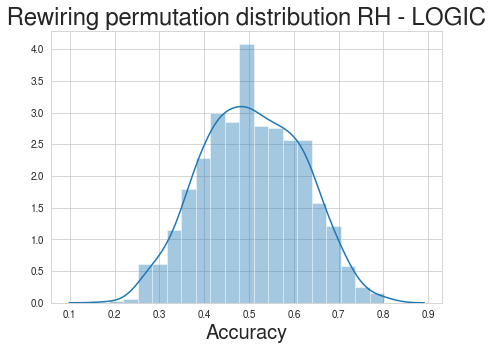

In [24]:
dist = np.loadtxt('PermutationTest_ConnectivityRewire_RH_all.csv',delimiter=',')
print 'Permutation p-value: p =', np.sum(dist>statistics_rh[0,0])/float(len(dist))
plt.figure(figsize=(7,5))
sns.distplot(dist)
plt.title('Rewiring permutation distribution RH - LOGIC',fontsize=24)
plt.xlabel('Accuracy',fontsize=20)

# Run across subject decoding on left-hand motor responses

In [26]:
tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

#### Run decoding

In [27]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

# rois = np.asarray([188,189,232]) - 1
# rois = np.asarray([188,232]) - 1
# rois = np.asarray([189]) - 1
rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,
                                                          ncvs=ncvs, nproc=nproc)
    

#### Compute statistics

In [28]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print 'Activity flow accuracy =', statistics_lh[0,0]
print 'p =', statistics_lh[0,1]
print 'Matched spatial correlation:', np.mean(rmatch)
print 'Mismatched spatial correlation:', np.mean(rmismatch)



Activity flow accuracy = 0.6041666666666666
p = 0.0023776187427737637
Matched spatial correlation: 0.014166793023292518
Mismatched spatial correlation: -0.014166793023291184


#### Load permutation distributions

Permutation p-value: p = 0.382


Text(0.5,0,'Accuracy')

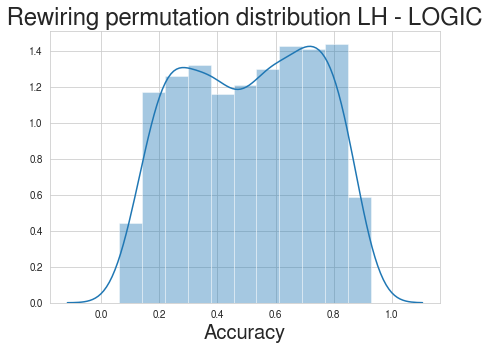

In [29]:
dist = np.loadtxt('PermutationTest_ConnectivityRewire_LH_all.csv',delimiter=',')
print 'Permutation p-value: p =', np.sum(dist>statistics_lh[0,0])/float(len(dist))
plt.figure(figsize=(7,5))
sns.distplot(dist)
plt.title('Rewiring permutation distribution LH - LOGIC',fontsize=24)
plt.xlabel('Accuracy',fontsize=20)

___

# Run analysis for Control (No threshold) variant

#### Compute average activity for each response, for each subject

In [816]:
scount = 0
actflow_rh = np.zeros(data_task_rh.shape)
actflow_lh = np.zeros(data_task_lh.shape)
for scount in range(len(subjNums)):
    # RMID
    actflow_rh[target_ind,0,scount] = actflow_predictions_control[scount,:,2]
    # RIND
    actflow_rh[target_ind,1,scount] = actflow_predictions_control[scount,:,3]
    # LMID
    actflow_lh[target_ind,0,scount] = actflow_predictions_control[scount,:,0]
    # LIND
    actflow_lh[target_ind,1,scount] = actflow_predictions_control[scount,:,1]


# Run across subject decoding on right-hand motor responses

#### Run decoding

In [817]:
tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

# tvals = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputRH_mask_tvals.dscalar.nii').get_data())
# pos_ind = np.where(tvals>0)[0]
# neg_ind = np.where(tvals<0)[0]

# actflow_rh_downsampled = np.zeros((2,2,len(subjNums)))
# data_rh_downsampled =  np.zeros((2,2,len(subjNums)))

# actflow_rh_copy = stats.zscore(actflow_rh,axis=0)
# data_rh_copy = stats.zscore(data_task_rh,axis=0)
# actflow_rh_downsampled[0,:,:] = np.mean(actflow_rh_copy[pos_ind,:,:],axis=0)
# actflow_rh_downsampled[1,:,:] = np.mean(actflow_rh_copy[neg_ind,:,:],axis=0)
# data_rh_downsampled[0,:,:] = np.mean(data_rh_copy[pos_ind,:,:],axis=0)
# data_rh_downsampled[1,:,:] = np.mean(data_rh_copy[neg_ind,:,:],axis=0)


In [818]:
tools_group = reload(tools_group)
nproc = 20
nResponses = 2
ncvs = 1

# rois = np.asarray([8,52,9])-1
# rois = np.asarray([8,52])-1
rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])

roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_rh[target_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_rh[target_ind,:,:],axis=0).copy()
realdata = data_task_rh[roi_ind,:,:].copy()
flowdata = actflow_rh[roi_ind,:,:].copy()


distances_baseline_rh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_rh[0,:],rmatch,rmismatch = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,
                                                          ncvs=ncvs, nproc=nproc)

#### Compute statistics

In [819]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_rh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_rh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_rh[0,0] = np.mean(distances_baseline_rh[0,:])
statistics_rh[0,1] = p

print 'Activity flow accuracy =', statistics_rh[0,0]
print 'p =', statistics_rh[0,1]
print 'Matched spatial correlation:', np.mean(rmatch)
print 'Mismatched spatial correlation:', np.mean(rmismatch)



Activity flow accuracy = 0.510416666667
p = 0.414331714586
Matched spatial correlation: -0.00689735174473
Mismatched spatial correlation: -0.00799503441578


# Run across subject decoding on left-hand motor responses

In [820]:
tmp = np.squeeze(nib.load('/projects3/SRActFlow/data/results/GroupfMRI/MotorRegionsMasksPerSubj/sractflow_smn_outputLH_mask.dscalar.nii').get_data())

targetmask_ind = np.where(tmp==True)[0]

#### Run decoding

In [821]:
tools_group = reload(tools_group)
nproc = 20
ncvs = 1

# rois = np.asarray([188,189,232]) - 1
# rois = np.asarray([188,232]) - 1
# rois = np.asarray([189]) - 1
rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser2==roi+1)[0])
    
roi_ind = np.intersect1d(targetmask_ind,roi_ind)
# roi_ind = targetmask_ind

# realdata = stats.zscore(data_task_lh[roi_ind,:,:],axis=0).copy()
# flowdata = stats.zscore(actflow_lh[roi_ind,:,:],axis=0).copy()
realdata = data_task_lh[roi_ind,:,:].copy()
flowdata = actflow_lh[roi_ind,:,:].copy()


distances_baseline_lh = np.zeros((1,len(subjNums)*nResponses))
distances_baseline_lh[0,:],rmatch,rmismatch = tools_group.actflowDecodings(realdata,
                                                          flowdata,effects=True,
                                                          ncvs=ncvs, nproc=nproc)
    

#### Compute statistics

In [822]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],2))
ntrials = len(subjNums)*2
p = stats.binom_test(np.mean(distances_baseline_lh[0,:])*ntrials,n=ntrials,p=0.5)
if np.mean(distances_baseline_lh[0,:])>0.5:
    p = p/2.0
else:
    p = 1.0-p/2.0

    
statistics_lh[0,0] = np.mean(distances_baseline_lh[0,:])
statistics_lh[0,1] = p

print 'Activity flow accuracy =', statistics_lh[0,0]
print 'p =', statistics_lh[0,1]
print 'Matched spatial correlation:', np.mean(rmatch)
print 'Mismatched spatial correlation:', np.mean(rmismatch)



Activity flow accuracy = 0.484375
p = 0.640840572891
Matched spatial correlation: 0.00283976933987
Mismatched spatial correlation: 0.00257008178502


___